# Assignment 2

**1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?**

<Figure size 576x432 with 0 Axes>

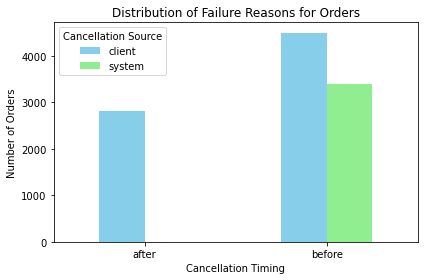

cancellation_timing  cancellation_source
after                client                 2811
                     system                    3
before               client                 4496
                     system                 3406
dtype: int64
Category with the highest number of orders: ('before', 'client')


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
data_orders = pd.read_csv("./datasets/data_orders.csv")

# Create a new column to categorize failure reasons
data_orders['failure_reason'] = 'No offer'

data_orders.loc[(data_orders['is_driver_assigned_key'] == 1) & (data_orders['order_status_key'] == 4),
                'failure_reason'] = 'Client cancelled after driver assigned'
data_orders.loc[(data_orders['is_driver_assigned_key'] == 1) & (data_orders['order_status_key'] == 9),
                'failure_reason'] = 'System cancelled after driver assigned'

data_orders.loc[(data_orders['is_driver_assigned_key'] == 0) & (data_orders['order_status_key'] == 4),
                'failure_reason'] = 'Client cancelled before driver assigned'
data_orders.loc[(data_orders['is_driver_assigned_key'] == 0) & (data_orders['order_status_key'] == 9),
                'failure_reason'] = 'System cancelled before driver assigned'

# Separate failure reasons into 'before' and 'after' categories
data_orders['cancellation_timing'] = data_orders['failure_reason'].apply(lambda x: 'before' if 'before' in x else 'after')

# Separate failure reasons into 'client' and 'system' categories
data_orders['cancellation_source'] = data_orders['failure_reason'].apply(lambda x: 'client' if 'Client' in x else 'system')

# Count the number of orders in each failure reason category
failure_reason_counts = data_orders.groupby(['cancellation_timing', 'cancellation_source']).size()

# Plot the distribution of failure reasons
plt.figure(figsize=(8, 6))
failure_reason_counts.unstack().plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Distribution of Failure Reasons for Orders')
plt.xlabel('Cancellation Timing')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.legend(title='Cancellation Source')
plt.tight_layout()
plt.show()

print(failure_reason_counts)
# Print the category with the highest number of orders
print("Category with the highest number of orders:", failure_reason_counts.idxmax())


**2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?**

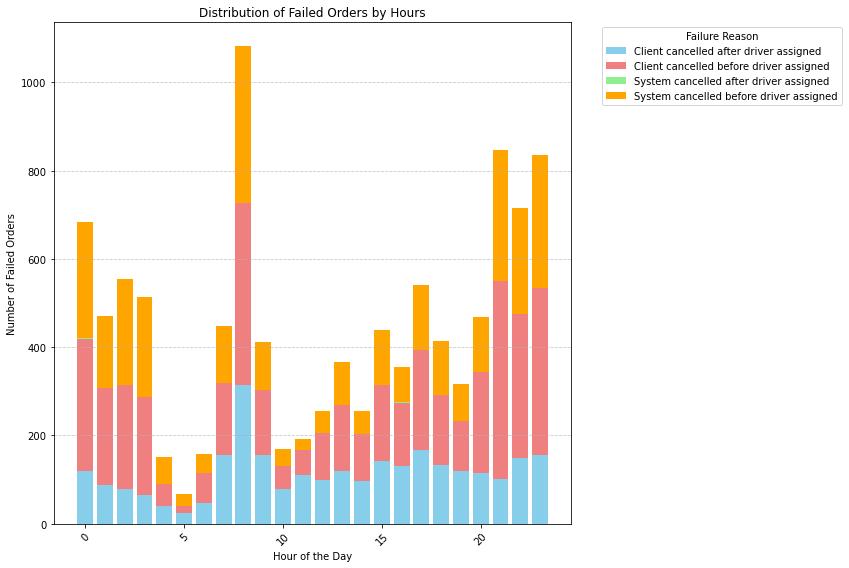

Hour with the most failed orders: 8


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract hour from order_datetime
data_orders['order_hour'] = pd.to_datetime(data_orders['order_datetime']).dt.hour

# Group data by hour and failure reason
grouped_data =data_orders.groupby(['order_hour', 'failure_reason']).size().unstack(fill_value=0)

# Plot the distribution of failed orders by hours
plt.figure(figsize=(12, 8))

# Define colors for different failure reasons
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'yellow']

# Plot each failure reason separately with customized colors
for i, reason in enumerate(grouped_data.columns):
    plt.bar(grouped_data.index, grouped_data[reason], bottom=grouped_data.iloc[:, :i].sum(axis=1), color=colors[i], label=reason)

plt.title('Distribution of Failed Orders by Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Failed Orders')
plt.xticks(rotation=45)
plt.legend(title='Failure Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.tight_layout()
plt.show()

# Find the hour with the highest total failed orders
total_failed_orders_by_hour = grouped_data.sum(axis=1)
hour_with_most_failures = total_failed_orders_by_hour.idxmax()
print("Hour with the most failed orders:", hour_with_most_failures)


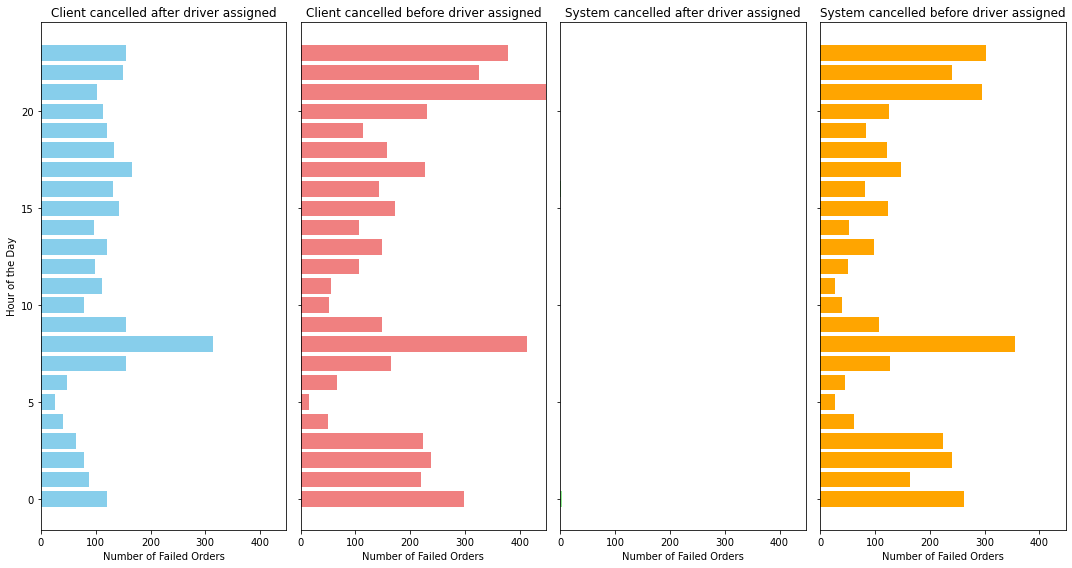

In [6]:
# Extract hour from order_datetime
data_orders['order_hour'] = pd.to_datetime(data_orders['order_datetime']).dt.hour

# Group data by hour and failure reason
grouped_data = data_orders.groupby(['order_hour', 'failure_reason']).size().unstack(fill_value=0)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 8), sharey=True)

# Define colors for different failure reasons
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'yellow']

# Plot each failure reason separately with customized colors
for i, (reason, ax) in enumerate(zip(grouped_data.columns, axes)):
    ax.barh(grouped_data.index, grouped_data[reason], color=colors[i])
    ax.set_title(reason)
    ax.set_xlabel('Number of Failed Orders')
    if i == 0:
        ax.set_ylabel('Hour of the Day')
    ax.set_xlim(0, max(grouped_data.max()))

plt.tight_layout()
plt.show()

**Explained:** 

**Morning Rush Hour:** The spike in failed orders around 8 AM might coincide with the morning rush hour, where there could be a high demand for rides, leading to delays or an overloaded system that prompts cancellations.
**Evening Rush Hour:** Similarly, the evening peak around 9 PM to 11 PM likely corresponds with the evening rush hour. During this time, clients may cancel after being assigned a driver due to long wait times, or the system may auto-cancel if it cannot allocate drivers in a timely manner.

These peaks in cancellations could be due to several **factors** such as:

**Increased Demand:** High demand during rush hours may lead to longer wait times, causing impatience and a higher rate of cancellations by clients.

**Traffic Congestion:** Drivers might be getting stuck in traffic, leading to system-initiated cancellations if they cannot reach the client within a certain timeframe.

**Operational Challenges:** The system might also have a threshold for how long it will attempt to match a driver before timing out, leading to cancellations.

**3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?**

<Figure size 864x576 with 0 Axes>

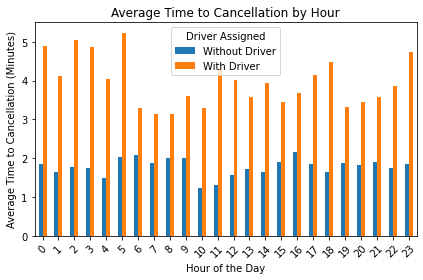

In [7]:
# Filter out outliers (e.g., cancellation times > 3600 seconds)
data_orders = data_orders[data_orders['cancellations_time_in_seconds'] <= 3600]

# Calculate cancellation time in minutes
data_orders['cancellations_time_minutes'] = data_orders['cancellations_time_in_seconds'] / 60

# Convert order_datetime to datetime
data_orders['order_datetime'] = pd.to_datetime(data_orders['order_datetime'])

# Extract hour from order_datetime
data_orders['order_hour'] = data_orders['order_datetime'].dt.hour

# Group data by hour and whether driver assigned or not, and calculate mean cancellation time
grouped_data = data_orders.groupby(['order_hour', 'is_driver_assigned_key'])['cancellations_time_minutes'].mean().unstack()

# Plot the average time to cancellation with and without driver by the hour
plt.figure(figsize=(12, 8))
grouped_data.plot(kind='bar')
plt.title('Average Time to Cancellation by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Time to Cancellation (Minutes)')
plt.xticks(rotation=45)
plt.legend(['Without Driver', 'With Driver'], title='Driver Assigned')
plt.tight_layout()
plt.show()

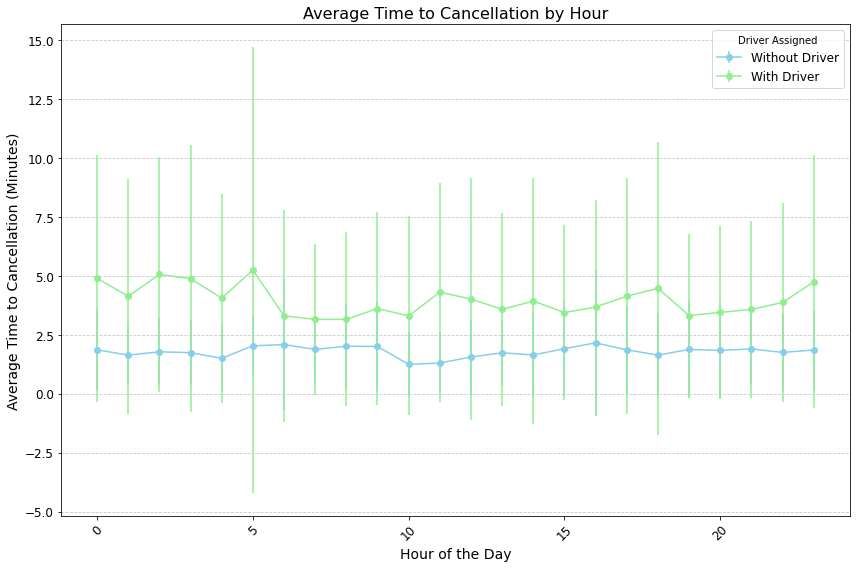

In [8]:
# Filter out outliers (e.g., cancellation times > 3600 seconds)
data_orders = data_orders[data_orders['cancellations_time_in_seconds'] <= 3600]

# Calculate cancellation time in minutes
data_orders['cancellations_time_minutes'] = data_orders['cancellations_time_in_seconds'] / 60

# Convert order_datetime to datetime
data_orders['order_datetime'] = pd.to_datetime(data_orders['order_datetime'])

# Extract hour from order_datetime
data_orders['order_hour'] = data_orders['order_datetime'].dt.hour

# Group data by hour and whether driver assigned or not, and calculate mean cancellation time and standard deviation
grouped_data = data_orders.groupby(['order_hour', 'is_driver_assigned_key'])['cancellations_time_minutes'].agg(['mean', 'std']).unstack()

# Plot the average time to cancellation with and without driver by the hour
plt.figure(figsize=(12, 8))

# Plotting
plt.errorbar(grouped_data.index, grouped_data['mean'][0], yerr=grouped_data['std'][0], label='Without Driver', color='skyblue', fmt='-o')
plt.errorbar(grouped_data.index, grouped_data['mean'][1], yerr=grouped_data['std'][1], label='With Driver', color='lightgreen', fmt='-o')

plt.title('Average Time to Cancellation by Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average Time to Cancellation (Minutes)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Driver Assigned', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Explain:** 

**Longer Wait Times with a Driver:** There is a clear trend that the average time to cancellation is generally longer when a driver has been assigned compared to when no driver is assigned. This suggests that clients may be more willing to wait once they know a driver is on the way.

**Consistency Throughout the Day:** The cancellation times without a driver assigned are fairly consistent throughout the day, with most of the times hovering around the 1 to 2 minutes mark.

**Variability with Driver Assignment:** The cancellation times with a driver assigned show more variability throughout the day.

**4. Plot the distribution of average ETA by hours. How can this plot be explained?**

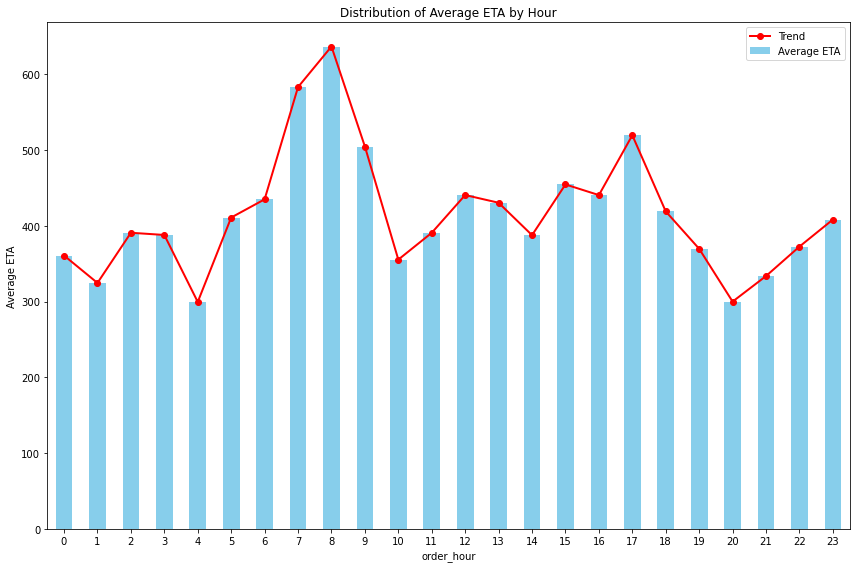

In [9]:
# Group data by hour and calculate the average ETA
average_eta_by_hour = data_orders.groupby('order_hour')['m_order_eta'].mean()

# Plot the distribution of average ETA by hours
plt.figure(figsize=(12, 8))
average_eta_by_hour.plot(kind='bar', color='skyblue', label='Average ETA')  # Bar plot for average ETA
plt.title('Distribution of Average ETA by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA')
plt.xticks(rotation=45)

# Overlay a line plot for trend analysis
average_eta_by_hour.plot(kind='line', color='red', marker='o', linestyle='-', linewidth=2, label='Trend')
plt.legend()  # Add legend for both bar and line plots

plt.tight_layout()
plt.show()



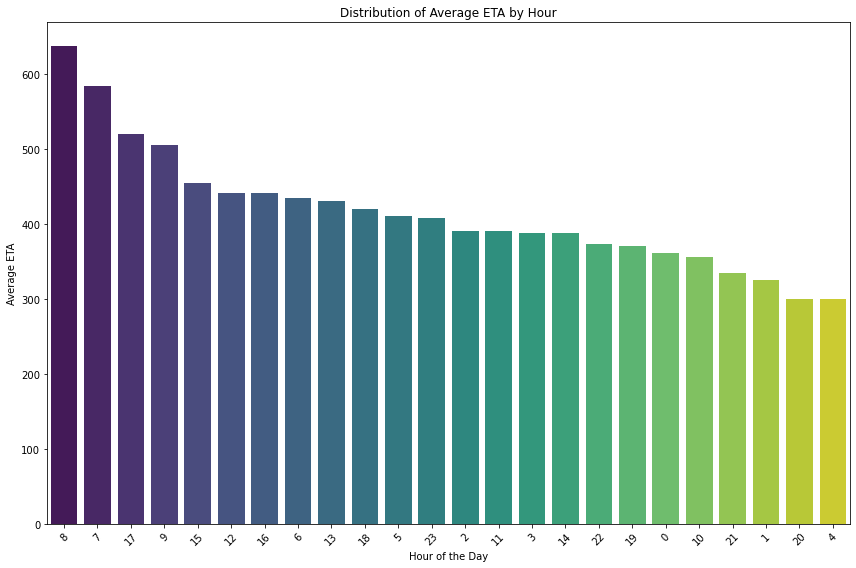

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by hour and calculate the average ETA
average_eta_by_hour = data_orders.groupby('order_hour')['m_order_eta'].mean().reset_index()

# Sort the average ETA by hour in descending order
average_eta_by_hour = average_eta_by_hour.sort_values(by='m_order_eta', ascending=False)

# Plot the distribution of average ETA by hours using Seaborn with a different color palette
plt.figure(figsize=(12, 8))
sns.barplot(data=average_eta_by_hour, x='order_hour', y='m_order_eta', order=average_eta_by_hour['order_hour'], palette='viridis')
plt.title('Distribution of Average ETA by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Explain：**

**Varying ETA Throughout the Day:** The average ETA fluctuates throughout the day, with certain hours showing a higher average ETA than others.

**Morning Peak:** There is a significant peak in average ETA around the 8th and 9th hours, which might correspond with the morning rush hour. This peak suggests that it takes longer for a driver to arrive at the customer's location, possibly due to increased traffic or higher demand leading to a shortage of nearby drivers.

**Midday Decrease:** The average ETA seems to drop during midday, around the 10th to 14th hours. This could indicate a period of lower traffic congestion and possibly a decreased demand for services, allowing drivers to reach customers more quickly.

**Evening Increase:** Another increase in average ETA occurs in the late afternoon and evening, around the 16th to 18th hours, likely aligning with the evening rush hour.

**Night Variation:** During late-night hours, from 22nd to the early hours of the next day, there is a noticeable variation with a spike around 23rd hour. This could be due to fewer drivers being available during these times or increased nighttime activities in certain areas that lead to higher demand.

**5. BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.**

In [23]:
import folium
import h3
from branca.colormap import linear

# Calculate the number of hexagons containing 80% of all orders
# Convert longitude and latitude to H3 hexagons of size 8
data_orders['h3_hex'] = data_orders.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1)

# Calculate the total number of orders
total_orders = len(data_orders)

# Calculate the number of hexes containing 80% of all orders
sorted_hex_counts = data_orders['h3_hex'].value_counts().sort_values(ascending=False)
cumulative_orders = 0
hexes_80_percent = []
for hex_, count in sorted_hex_counts.items():
    cumulative_orders += count
    hexes_80_percent.append(hex_)
    if cumulative_orders >= 0.8 * total_orders:
        break

# Create a dataframe with hexes containing 80% of all orders
data_hexes_80_percent = pd.DataFrame(hexes_80_percent, columns=['h3_hex'])

# Aggregate orders within the selected hexes
aggregated_orders = data_orders[data_orders['h3_hex'].isin(data_hexes_80_percent['h3_hex'])]

# Calculate the number of failed orders per hex
failed_orders_by_hex = aggregated_orders[aggregated_orders['order_status_key'] != 1]['h3_hex'].value_counts()

# Create a colormap for the number of failed orders
max_failures = failed_orders_by_hex.max()
colormap = linear.Reds_09.scale(0, max_failures)

# Create a map centered around the mean latitude and longitude of the aggregated orders
map_center = [aggregated_orders['origin_latitude'].mean(), aggregated_orders['origin_longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

# Add hexagons to the map and color them based on the number of failed orders
for hex_, count in failed_orders_by_hex.items():
    lat, lng = h3.h3_to_geo(hex_)
    color = colormap(count) if count > 0 else '#ffffff'  # White for hexagons without failed orders
    folium.RegularPolygonMarker([lat, lng], fill_color=color, fill_opacity=0.6, number_of_sides=6, radius=10).add_to(mymap)
    # Add text label showing the number of failed orders
    folium.Marker(location=[lat, lng], icon=folium.DivIcon(html=f'<div style="font-size: 10pt; color: black;">{count}</div>')).add_to(mymap)

# Add colormap to the map
colormap.caption = 'Number of Failed Orders'
mymap.add_child(colormap)

# Save the map to an HTML file
mymap.save("hex_map_with_labels.html")

# Display the map
mymap


In [12]:
import branca.colormap as cm

def lat_lng_to_h3(lat, lng, hex_size=8):
    return h3.geo_to_h3(lat, lng, hex_size)

data_orders['hex'] = data_orders.apply(
    lambda x: lat_lng_to_h3(x['origin_latitude'], x['origin_longitude']), axis=1)

failed_orders = data_orders[data_orders['order_status_key'].isin([4, 9])]
order_counts_per_hex = failed_orders['hex'].value_counts()

min_count = order_counts_per_hex.min()
max_count = order_counts_per_hex.max()

color_scale = cm.LinearColormap(
    colors=['#67B26F', '#F79D5C', '#F52F57', '#A20021'],
    vmin=min_count,
    vmax=max_count
)

color_scale = color_scale.to_step(n=5)
color_scale.caption = 'Number of Failed Orders'

median_latitude = data_orders['origin_latitude'].median()
median_longitude = data_orders['origin_longitude'].median()

map_with_hexes = folium.Map(location=[median_latitude, median_longitude], zoom_start=12)

for hex_id, count in order_counts_per_hex.items():
    hex_boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
    hex_boundary = [(coords[1], coords[0]) for coords in hex_boundary]
    
    hex_color = color_scale(count)
    
    folium.Polygon(
        locations=hex_boundary,
        color=hex_color,  # The outline color of the hexagon
        fill_color=hex_color,  # The fill color of the hexagon
        fill_opacity=0.7,  # The fill opacity of the hexagon
        weight=1.1,  # The line weight of the hexagon
    ).add_to(map_with_hexes)

color_scale.add_to(map_with_hexes)

map_with_hexes.save('map_with_hexes.html')
map_with_hexes